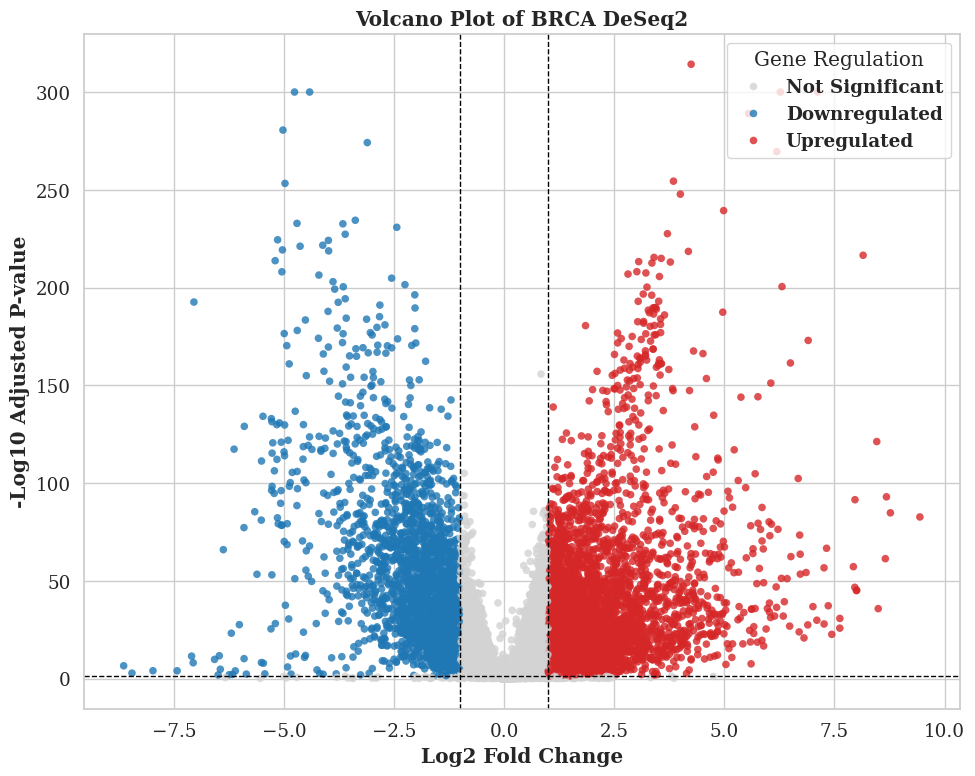

✅ Volcano plot saved as: /Users/apple/Desktop/BRCA/2.BRCA_deseq2_DEG_analysis/VolcanoPlot_BRCA_new.jpg


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# === Load BRCA DESeq2 Results ===
input_file = "/Users/apple/Desktop/BRCA/2.BRCA_deseq2_DEG_analysis/DESeq2_BRCA_all_results.csv"
df = pd.read_csv(input_file)

# === Check Required Columns ===
if 'padj' not in df.columns or 'log2FoldChange' not in df.columns:
    raise ValueError("The file must contain 'padj' and 'log2FoldChange' columns.")

# === Drop rows with NA padj or log2FC ===
df = df.dropna(subset=['padj', 'log2FoldChange'])

# === Cap padj values to avoid -log10(0) = Inf ===
df['padj'] = df['padj'].replace(0, 1e-300)

# === Define thresholds ===
log2fc_thresh = 1
fdr_thresh = 0.05

# === Annotate gene regulation status ===
def get_significance(row):
    if row['padj'] < fdr_thresh and row['log2FoldChange'] > log2fc_thresh:
        return 'Upregulated'
    elif row['padj'] < fdr_thresh and row['log2FoldChange'] < -log2fc_thresh:
        return 'Downregulated'
    else:
        return 'Not Significant'

df['Significance'] = df.apply(get_significance, axis=1)
df['-log10(padj)'] = -np.log10(df['padj'])

# === Plot setup (serif + bold) ===
sns.set(style="whitegrid", font_scale=1.2, rc={"font.family": "serif"})
plt.figure(figsize=(10, 8))

# === Define color palette ===
palette = {
    'Upregulated': '#d62728',       # Red
    'Downregulated': '#1f77b4',     # Blue
    'Not Significant': 'lightgrey'
}

# === Volcano Plot ===
sns.scatterplot(
    data=df,
    x='log2FoldChange',
    y='-log10(padj)',
    hue='Significance',
    palette=palette,
    alpha=0.8,
    edgecolor=None,
    s=30,
    linewidth=0
)

# === Add threshold lines ===
plt.axhline(-np.log10(fdr_thresh), linestyle='--', color='black', lw=1)
plt.axvline(x=log2fc_thresh, linestyle='--', color='black', lw=1)
plt.axvline(x=-log2fc_thresh, linestyle='--', color='black', lw=1)

# === Labels and formatting (bold serif) ===
plt.xlabel("Log2 Fold Change", fontweight='bold', fontfamily="serif")
plt.ylabel("-Log10 Adjusted P-value", fontweight='bold', fontfamily="serif")
plt.title("Volcano Plot of BRCA DeSeq2", fontweight='bold', fontfamily="serif")

# === Legend styling ===
plt.legend(title='Gene Regulation', loc='upper right', prop={'weight': 'bold', 'family': 'serif'})
plt.tight_layout()

# === Save Plot ===
output_dir = "/Users/apple/Desktop/BRCA/2.BRCA_deseq2_DEG_analysis"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "VolcanoPlot_BRCA_new.jpg")
plt.savefig(output_path, dpi=600, format='jpg')
plt.show()

print("✅ Volcano plot saved as:", output_path)

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Load expression and metadata ---
vst = pd.read_csv("BRCA_VST_Normalized_Matrix.csv", index_col=0)
meta = pd.read_csv("BRCA_Metadata_Final.csv", index_col=0)
vst = vst.loc[:, meta.index]
meta['condition'] = meta['shortLetterCode'].map({'TP': 'Tumor', 'NT': 'Normal'})
annotation = meta[['condition']]

# --- Heatmap function with FDR filtering ---
def plot_heatmap(top_genes_file, significance_file, title, output_file):
    top_genes = pd.read_csv(top_genes_file)['Gene'].dropna().unique()
    sig_df = pd.read_csv(significance_file)

    # Filter by FDR < 0.05
    sig_genes = sig_df[(sig_df['adj_p'] < 0.05) & (sig_df['Gene'].isin(top_genes))]['Gene'].unique()

    data = vst.loc[vst.index.intersection(sig_genes)]

    if data.empty:
        print(f"❌ No significant genes from top list in {significance_file}")
        return

    # Z-score normalization by row
    data_scaled = data.sub(data.mean(axis=1), axis=0).div(data.std(axis=1), axis=0)

    sns.set(font_scale=0.7)
    g = sns.clustermap(
        data_scaled,
        row_cluster=True,
        col_cluster=False,
        cmap='coolwarm',
        xticklabels=False,
        yticklabels=True,
        col_colors=annotation['condition'].map({'Tumor': 'orange', 'Normal': 'green'}),
        figsize=(10, 10)
    )

    g.fig.suptitle(title, fontsize=12)
    g.savefig(output_file, dpi=600, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved heatmap: {output_file}")

# --- Run for each panel ---
os.makedirs("Heatmaps_600DPI", exist_ok=True)

plot_heatmap("BRCA_Top30_Ferroptosis_Genes.csv",
             "BRCA_Significant_Ferroptosis_Genes.csv",
             "Top 30 Significant Ferroptosis Genes",
             "Heatmaps_600DPI/Ferroptosis_Heatmap.jpg")

plot_heatmap("BRCA_Top30_Cuproptosis_Genes.csv",
             "BRCA_Significant_Cuproptosis_Genes.csv",
             "Top 30 Significant Cuproptosis Genes",
             "Heatmaps_600DPI/Cuproptosis_Heatmap.jpg")

plot_heatmap("BRCA_Top30_ImmuneC7_Genes.csv",
             "BRCA_Significant_ImmuneC7_Genes_Collapsed.csv",
             "Top 30 Significant Immune C7 Genes",
             "Heatmaps_600DPI/ImmuneC7_Heatmap.jpg")

/opt/anaconda3/envs/GSEA/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


✅ Saved heatmap: Heatmaps_600DPI/Ferroptosis_Heatmap.jpg


/opt/anaconda3/envs/GSEA/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


✅ Saved heatmap: Heatmaps_600DPI/Cuproptosis_Heatmap.jpg


/opt/anaconda3/envs/GSEA/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


✅ Saved heatmap: Heatmaps_600DPI/ImmuneC7_Heatmap.jpg


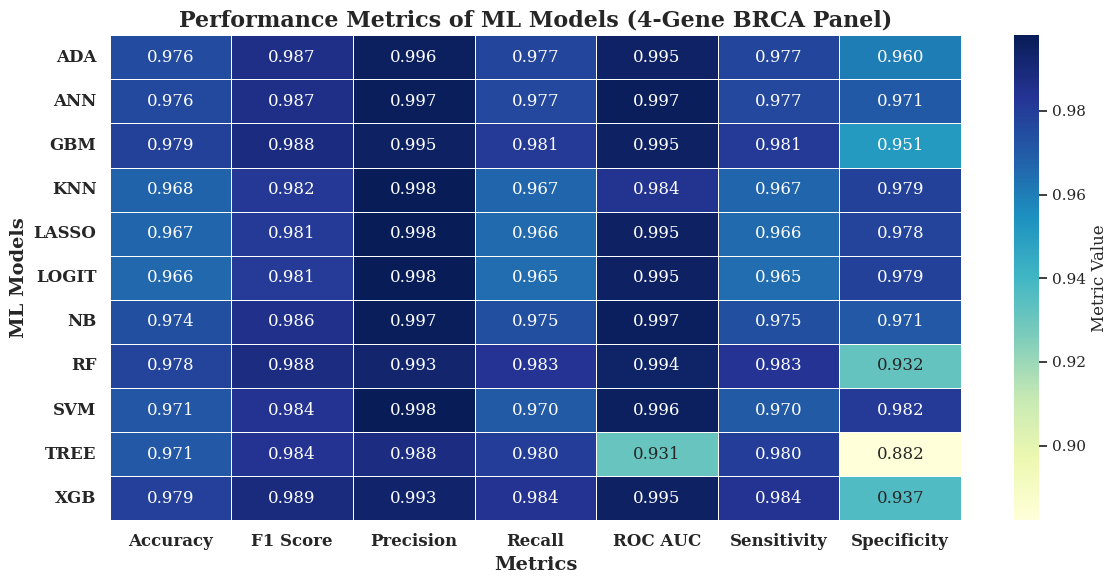

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load aggregated Excel file ===
file_path = "/Users/apple/Desktop/ML_Performance_BRCA_4GenePanel_Bootstrap_TrainTest.xlsx"
df = pd.read_excel(file_path)

# === Set "Model" column as index ===
df.set_index("Model", inplace=True)

# === Select only the performance metrics (not std columns) ===
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC', 'Sensitivity', 'Specificity']
df_heatmap = df[metrics]

# === Plot heatmap ===
plt.figure(figsize=(12, 6))
sns.set(font='serif', style='whitegrid')
ax = sns.heatmap(df_heatmap, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Metric Value"})

# === Customize appearance ===
ax.set_title("Performance Metrics of ML Models (4-Gene BRCA Panel)", fontsize=16, weight='bold', fontname='serif')
ax.set_xlabel("Metrics", fontsize=14, weight='bold', fontname='serif')
ax.set_ylabel("ML Models", fontsize=14, weight='bold', fontname='serif')
plt.xticks(fontsize=12, weight='bold', fontname='serif')
plt.yticks(fontsize=12, weight='bold', fontname='serif', rotation=0)

# === Save the figure ===
output_path = "/Users/apple/Desktop/Figure6A_Model_Performance_Heatmap.png"
plt.tight_layout()
plt.savefig(output_path, dpi=600)
plt.show()

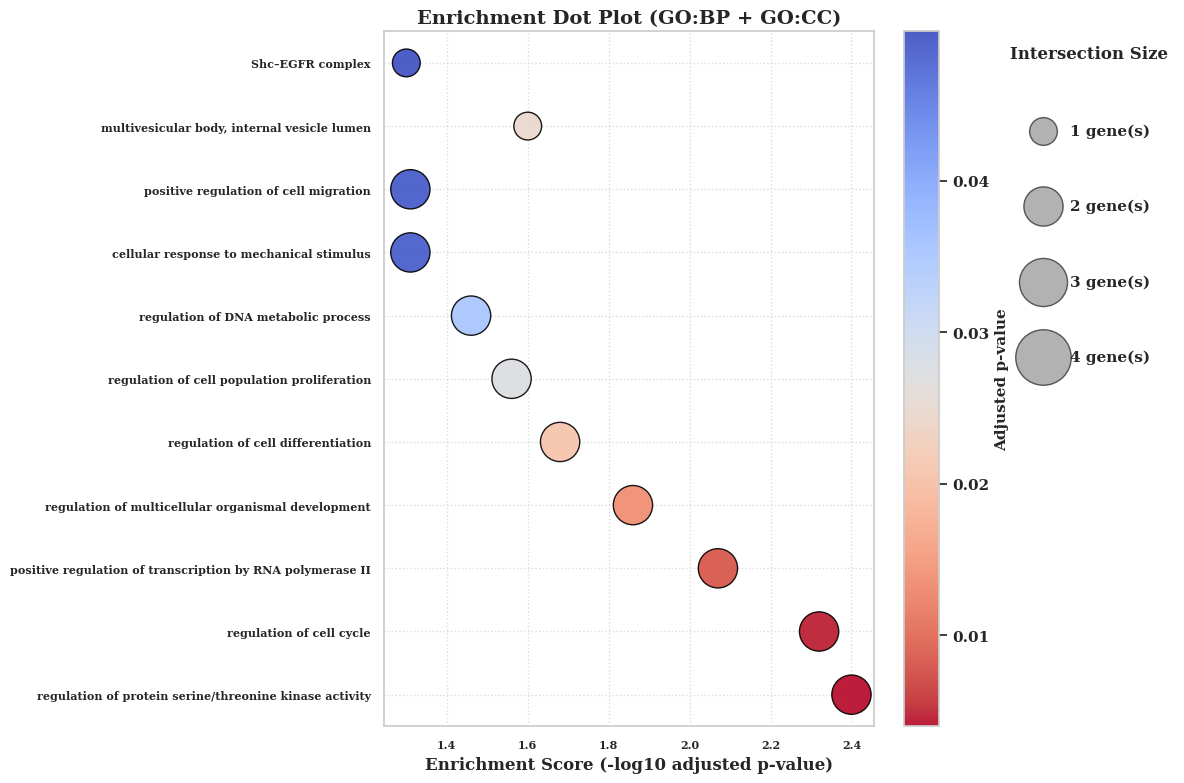

In [8]:
# Modified version: replace 'XX' style size legend with actual bubble-style markers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# Load dataset
full_data_str = """source	term_name	term_id	adjusted_p_value	negative_log10_of_adjusted_p_value	intersection_size
GO:BP	regulation of protein serine/threonine kinase activity	GO:0071900	0.003982	2.40	2
GO:BP	regulation of cell cycle	GO:0051726	0.004737	2.32	2
GO:BP	positive regulation of transcription by RNA polymerase II	GO:0045944	0.008451	2.07	2
GO:BP	regulation of multicellular organismal development	GO:2000026	0.013747	1.86	2
GO:BP	regulation of cell differentiation	GO:0045595	0.020974	1.68	2
GO:BP	regulation of cell population proliferation	GO:0042127	0.027414	1.56	2
GO:BP	regulation of DNA metabolic process	GO:0051052	0.035020	1.46	2
GO:BP	cellular response to mechanical stimulus	GO:0071260	0.048660	1.31	2
GO:BP	positive regulation of cell migration	GO:0030335	0.048860	1.31	2
GO:CC	multivesicular body, internal vesicle lumen	GO:0097489	0.024940	1.60	1
GO:CC	Shc–EGFR complex	GO:0070435	0.049880	1.30	1
"""

from io import StringIO
df = pd.read_csv(StringIO(full_data_str), sep="\t")

# Plot with proper filled bubbles
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

bubble = plt.scatter(
    x=df["negative_log10_of_adjusted_p_value"],
    y=df["term_name"],
    s=df["intersection_size"] * 400,
    c=df["adjusted_p_value"],
    cmap="coolwarm_r",
    edgecolor='black',
    alpha=0.9,
    marker='o'
)

import matplotlib as mpl

# Set serif and bold globally
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'bold'

# Colorbar and labels
cbar = plt.colorbar(bubble)
cbar.set_label("Adjusted p-value", fontsize=11, fontweight='bold', family='serif')

plt.xlabel("Enrichment Score (-log10 adjusted p-value)", fontsize=12, fontweight='bold', family='serif')
plt.title("Enrichment Dot Plot (GO:BP + GO:CC)", fontsize=14, fontweight='bold', family='serif')
plt.xticks(fontsize=8, fontweight='bold', family='serif')
plt.yticks(fontsize=8, fontweight='bold', family='serif')
plt.grid(True, linestyle=":", alpha=0.7)

# Bubble size legend using actual filled circles
for size in [   1,  2,  3,  4]:
    plt.scatter([], [], s=size * 400, c='gray', alpha=0.6, edgecolors='black', label=f"{size} gene(s)")

plt.legend(
    title="Intersection Size",
    bbox_to_anchor=(1.25, 1),
    loc='upper left',
    frameon=False,
    fontsize=8,
    title_fontsize=12,
    labelspacing=4.0,
    prop={'family': 'serif', 'weight': 'bold'}
)

plt.tight_layout()

# Save as high-resolution TIFF
plt.savefig("Enrichment_DotPlot.png", format='png', dpi=600, bbox_inches='tight')

plt.show()